In [10]:
import pandas as pd
import copy
import numpy as np
import matplotlib.pyplot as mp
import scipy.signal as sp
from scipy.ndimage import gaussian_filter
import spec_funcs as sf

In [11]:
# change to gui at later date


# load requried file (.csv)
dir = 'C:\\Users\\sk88\\Desktop'
folder = 'New folder' 
file = 'Noise01.csv' 
path = dir + '\\' + folder + '\\' + file

# input known cavity constants
FSR = 599.646
delta_nu = 285.267e-3
scan_volt = 10
# determine threshold values
peak_thresh = 0.8
noise_thresh = 0.035

# extract raw data to data frame
raw_data = pd.read_csv(path, delimiter=',', header=0)

# split data frame to components
time_base = raw_data.iloc[:,0]
scan_amp = raw_data.iloc[:,1]
transmitted = raw_data.iloc[:,3]
reflected = raw_data.iloc[:,2]

# re-scale data to remove -ve values (update to remove background in future)
if np.amin(transmitted) < 0:
    transmitted = transmitted + np.abs(np.amin(transmitted))
    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


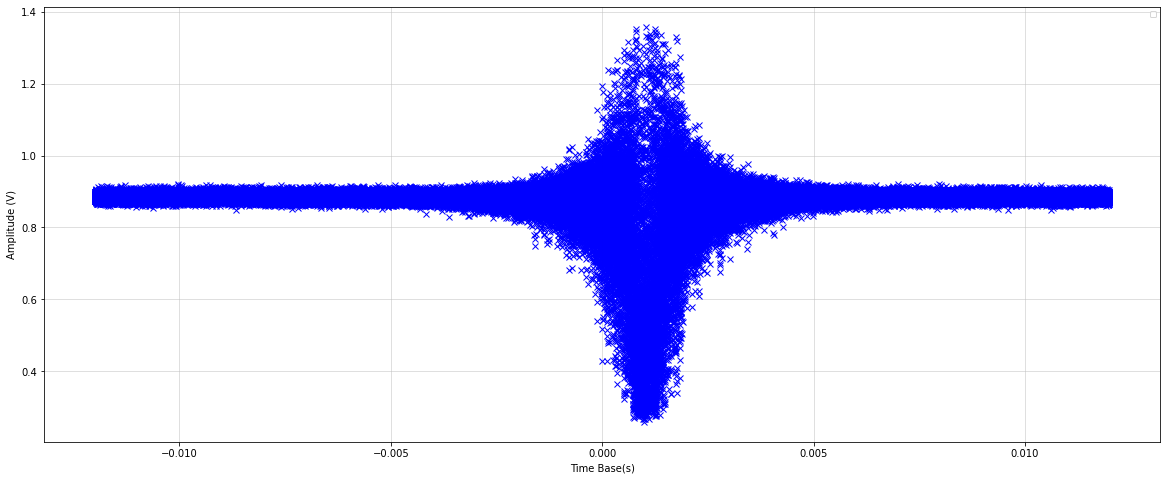

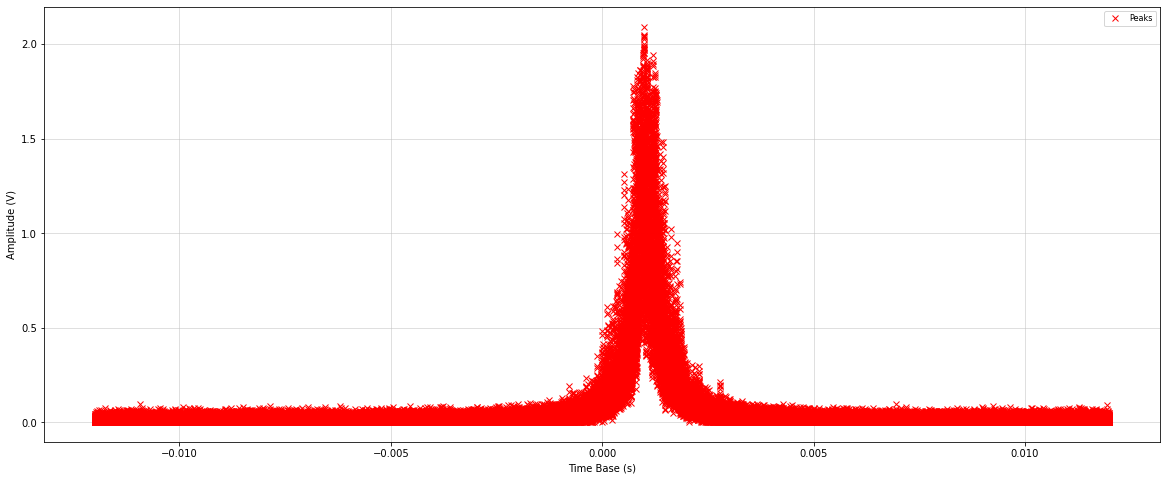

In [21]:
# plot to show spectrum
fig_1, ax_1 = mp.subplots(nrows=1, ncols=1, figsize=(20,8), sharex=False, sharey=True)

#ax_1.plot(frequency, reflected, color='orange', marker='.', linestyle='None', label='Scan Amp')
ax_1.plot(time_base, reflected, 'xb')

ax_1.set(xlabel='Time Base(s)', ylabel='Amplitude (V)')
ax_1.legend(loc='best', fontsize=8)
ax_1.legend(loc='best', fontsize=8)

ax_1.grid(True)
ax_1.grid(True, color='silver', linewidth=0.5)

fig_1, ax_1 = mp.subplots(nrows=1, ncols=1, figsize=(20,8), sharex=False, sharey=True)

#ax_1.plot(frequency, reflected, color='orange', marker='.', linestyle='None', label='Scan Amp')
ax_1.plot(time_base, transmitted, color='red', marker='x', linestyle='None', label='Peaks')

ax_1.set(xlabel='Time Base (s)', ylabel='Amplitude (V)')
ax_1.legend(loc='best', fontsize=8)
ax_1.legend(loc='best', fontsize=8)

ax_1.grid(True)
ax_1.grid(True, color='silver', linewidth=0.5)

50724.92642051281 5072.492642051281


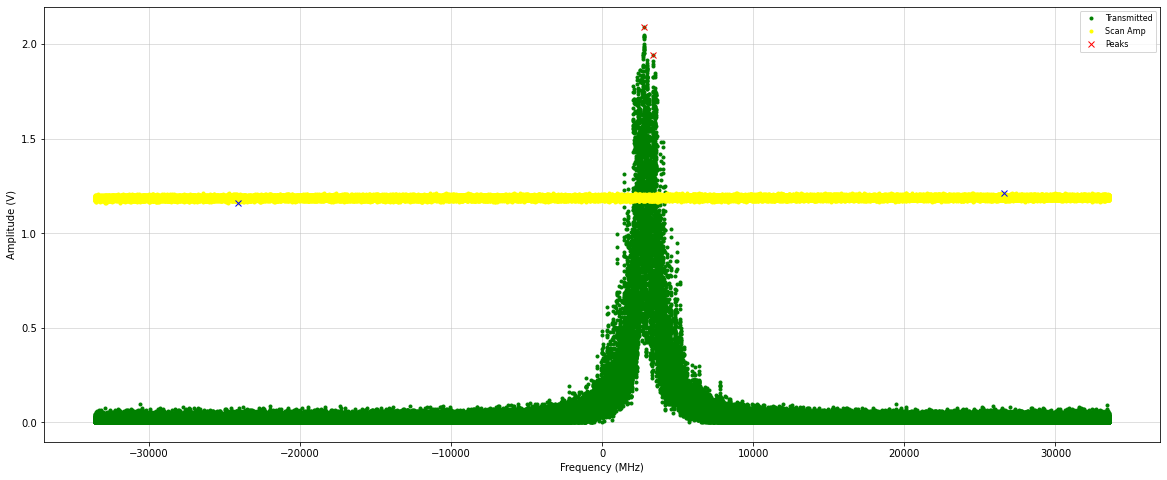

In [13]:
# find peaks and maximum peak values
peak_thresh = np.amax(transmitted) * peak_thresh
peaks, _ = sp.find_peaks(transmitted, prominence=peak_thresh)

# find extremes of scan amplitude
scan_index = [np.argmin(scan_amp), np.argmax(scan_amp)]

# calculate frequency step size from known FSR - change x-axis from time to frequency
peak_range = []

for index in peaks:
    if index > scan_index[0] and index < scan_index[1]:
        peak_range.append(index)    

freq_step = ((len(peak_range) - 1) * FSR) / (peak_range[-1] - peak_range[0])
x_scale = np.amin(np.where(time_base >= 0))
frequency = np.arange(start=-x_scale, stop=time_base.size - x_scale, step=1) * freq_step

# calculate scan frequency range
scan_freq = (freq_step * (scan_index[1] - scan_index[0]))
volt_hz = scan_freq / scan_volt
print(scan_freq, volt_hz)

# plot to show spectrum
fig_1, ax_1 = mp.subplots(nrows=1, ncols=1, figsize=(20,8), sharex=False, sharey=True)

ax_1.plot(frequency, transmitted, color='green', marker='.', linestyle='None', label='Transmitted')
ax_1.plot(frequency, scan_amp, color='yellow', marker='.', linestyle='None', label='Scan Amp')
#ax_1.plot(frequency, reflected, color='orange', marker='.', linestyle='None', label='Scan Amp')
ax_1.plot(frequency[peaks], transmitted[peaks], color='red', marker='x', linestyle='None', label='Peaks')
ax_1.plot(frequency[scan_index[1]], scan_amp[scan_index[1]], 'xb')
ax_1.plot(frequency[scan_index[0]], scan_amp[scan_index[0]], 'xb')

ax_1.set(xlabel='Frequency (MHz)', ylabel='Amplitude (V)')
ax_1.legend(loc='best', fontsize=8)
ax_1.legend(loc='best', fontsize=8)

ax_1.grid(True)
ax_1.grid(True, color='silver', linewidth=0.5)


[2.07133468e+00 5.31030553e-02 2.87072166e+03 1.33869688e+03]


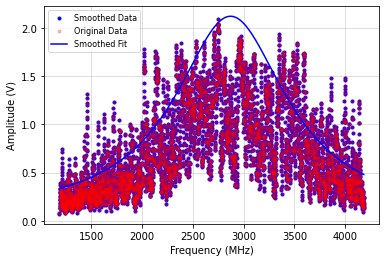

In [14]:
# calculate a threshold for isolating a lorentzian
threshold = transmitted[peaks] * noise_thresh
# copy peaks data
start = copy.deepcopy(peaks)
stop = copy.deepcopy(peaks)
# calculate approximate halfmax for lorentzian
halfmax = np.array(transmitted[peaks]) * 0.5

# gaussian filter and fitting params
sig = 0.25
meth = 'trf'
# tolerance value for initial fit conditions (amp, offset, x_0, gamma)
tolerance = [0.01, 0.25, 0.1, 0.5]
# find bounds for lorentzians (extreme edges)
lower = []
upper = []

for index, value in enumerate(threshold):
    # find lowest acceptable index for height data
    while transmitted[start[index]] > value:
        start[index] -= 1
    # find highest acceptable index for height data
    while transmitted[stop[index]] > value:
        stop[index] += 1

# smooth lorentzian data
spike = []
for index, value in enumerate(start):
    spike.append(gaussian_filter(transmitted[value:stop[index]], sigma=sig))
    # find acceptable indexes for edges of halfmax position
    top = np.where(spike[index] >= halfmax[index])
    lower.append(np.amin(top))
    upper.append(np.amax(top))

# convert to array for processing
spike = np.array(spike, dtype=object)

gamma = []
x = []
x_0 = []
height = []
amp = []
amp_0 = []
fit_data = []
x_axis = []
fitted = []

# generate fits to the smoothed data
for index, value in enumerate(upper):
    
    # calculate params for fitting from smoothed data - convert to frequency 
    gamma.append((value - lower[index]) * freq_step)
    x.append(range(len(spike[index])) * freq_step + frequency[start[index]])
    x_0.append(np.argmax(spike[index]) * freq_step + frequency[start[index]])
    height.append(spike[index])
    amp.append(np.amax(spike[index]))
    amp_0.append(np.amin(spike[index]))

    # fitting to data
    params = [amp[index], amp_0[index], x_0[index], gamma[index]]
    low_lims = []
    high_lims = []
    for index_2, value in enumerate(params):
        if value >= 0:
            low_lims.append(value * (1 - tolerance[index_2]))
            high_lims.append(value * (1 + tolerance[index_2]))
        else:
            low_lims.append(value * (1 + tolerance[index_2]))
            high_lims.append(value * (1 - tolerance[index_2]))
    
    limits = (low_lims, high_lims)
    fit_data.append(sf.fitlorentz(x[index], height[index], params, meth, limits))
    x_axis.append(frequency[start[index]:stop[index]])
    fitted.append(sf.lorentzian(x_axis[index], *fit_data[index][0]))

x_axis = np.array(x_axis, dtype=object)
fitted = np.array(fitted, dtype=object)

fig, ax = mp.subplots()
ax.plot(x_axis[0], spike[0], color='blue', marker='.', linestyle='None', label='Smoothed Data')
ax.plot(x_axis[0], transmitted[start[0]:stop[0]], color='red', marker='.', linestyle='None', alpha=0.25, label='Original Data')
ax.plot(x_axis[0], fitted[0], 'b', label='Smoothed Fit')

ax.set(xlabel='Frequency (MHz)', ylabel='Amplitude (V)')
ax.legend(loc='best', fontsize=8)
ax.legend(loc='best', fontsize=8)

ax.grid(True)
ax.grid(True, color='silver', linewidth=0.5)

print(fit_data[0][0])


In [15]:
np.abs(frequency[peak_range[0]] - frequency[peak_range[1]])

599.6459999999997

(array([2.07133468e+00, 5.31030553e-02, 2.87072166e+03, 1.33869688e+03]), array([3.13775685e-02, 3.34797748e-02, 5.76623214e+00, 3.94985894e+01]))
(array([2.07133468e+00, 4.57813107e-02, 2.89543969e+03, 1.56420478e+03]), array([3.18585648e-02, 3.38070778e-02, 6.67026436e+00, 4.52008905e+01]))


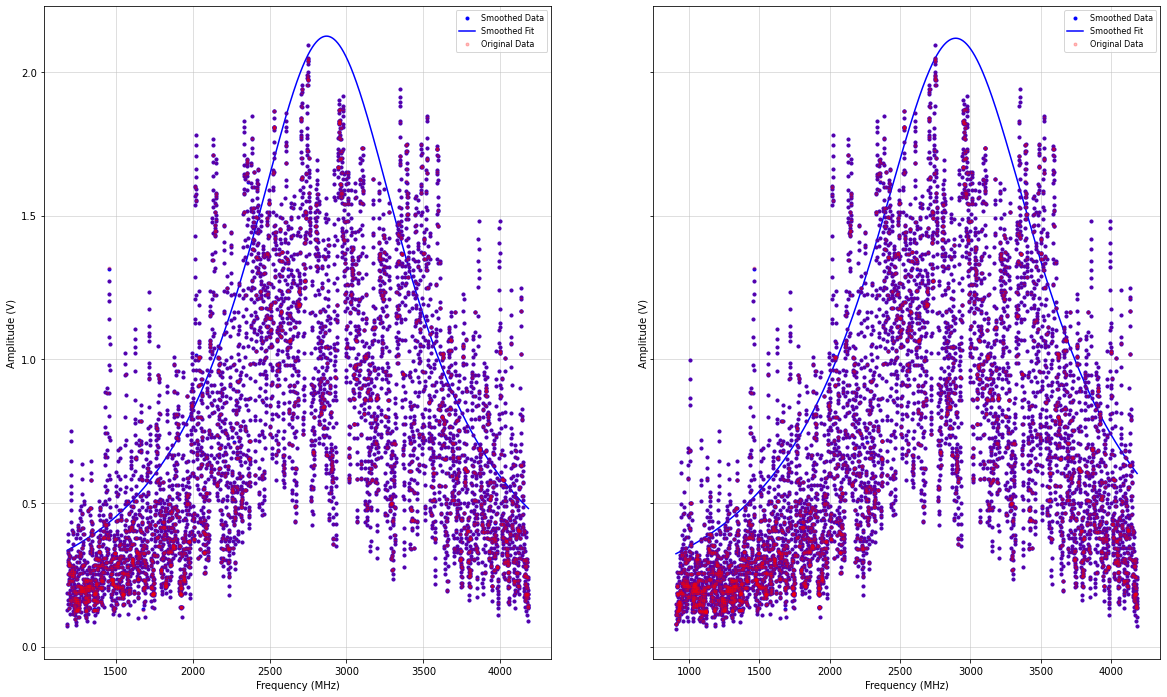

In [16]:
# plot gaussian fit to data  

# define figure and axes
fig_2, ax_2 = mp.subplots(nrows=1, ncols=len(peaks), figsize=(20,12), sharex=False, sharey=True)
# plot data

for index, axis in enumerate(ax_2):
     # plot smoothed data with fit
    axis.plot(x_axis[index], spike[index], color='blue', marker='.', linestyle='None', label='Smoothed Data')
    axis.plot(x_axis[index], fitted[index], color='blue', marker='None', linestyle='-', label='Smoothed Fit')
    # plot original data
    axis.plot(x_axis[index], transmitted[start[index]:stop[index]], color='red', marker='.', linestyle='None', alpha=0.25, label='Original Data')

    # format plots
    axis.set(xlabel='Frequency (MHz)', ylabel='Amplitude (V)')
    axis.legend(loc='best', fontsize=8)
    axis.legend(loc='best', fontsize=8)
    axis.grid(True)
    axis.grid(True, color='silver', linewidth=0.5)
    print(fit_data[index])

mp.show()

In [17]:
line = 0

for index in np.arange(len(fit_data)):
    line += fit_data[index][0][3]
    print(fit_data[index][0][3])


line_av = line/len(fit_data)
print(line_av)
print(line_av/delta_nu)
print(delta_nu)


1338.696882051282
1564.2047794871794
1451.4508307692308
5088.043239383563
0.285267


In [18]:
print(np.amax(transmitted))

2.09229


In [19]:
ref_av = np.average(reflected)
ref_min = np.amin(reflected)

contrast = (ref_av - ref_min) / ref_av
print(contrast)

0.7034293123985491


[ 1.85969454e+00  1.06773006e+00 -7.82124850e+03  8.73856408e+03] [1.86673202e+05 7.90859675e+01 1.08509871e+08 4.08473228e+08]


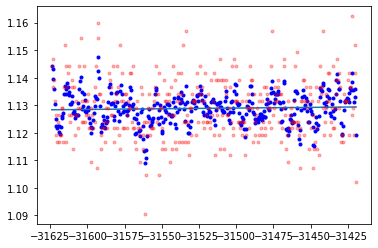

In [20]:
signal = 1/reflected[3800:4200]
freq = frequency[3800:4200]
max = np.amax(signal)
smooth = gaussian_filter(signal, sigma=1)
min = np.amin(smooth)

fit, err = sf.fitlorentz(freq, signal, [max, min, -1510, delta_nu], meth='trf', lims=([max*0.6, min*0.9, -np.inf, -np.inf],[max*1.6, min*1.1, np.inf, np.inf]))
mp.plot(freq, smooth, '.b')
mp.plot(freq, sf.lorentzian(freq, *fit))
mp.plot(freq, signal, '.r', alpha= 0.3)

print(fit, err)